In [1]:
from utils import PaintingsDataset
import random
from torchvision import transforms

# Building the dataset

image_dir = '../data/resized/resized/'

transform = transforms.Compose([
    transforms.Resize((128,128)), # Standardizing the size of the images
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])



paintings = PaintingsDataset(image_dir, transform)

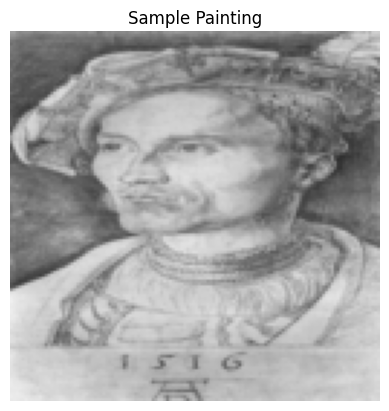

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting an example from  the dataset
n = len(paintings)
integer = random.randint(0,n)
image = paintings[integer].numpy()*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting')
plt.show()


In [3]:
from torch.utils.data import DataLoader

dataloader = DataLoader(paintings, batch_size=16)

In [4]:
from utils import Generator, Discriminator

latent_dim = 128
channels_out = 3
channels_in = 3

G = Generator(latent_dim, channels_out)
D = Discriminator(channels_in)

In [5]:
from utils import Unet_Discriminator

D_unet = Unet_Discriminator(3, 2)

D_unet(paintings[0].unsqueeze(0))[1][0]

tensor([[[0.5008, 0.5002, 0.4999,  ..., 0.5001, 0.5001, 0.4999],
         [0.5008, 0.5011, 0.5007,  ..., 0.5005, 0.5003, 0.4998],
         [0.5011, 0.5011, 0.5003,  ..., 0.5005, 0.5003, 0.4996],
         ...,
         [0.5012, 0.5012, 0.5010,  ..., 0.5006, 0.5001, 0.4999],
         [0.5012, 0.5011, 0.5012,  ..., 0.5005, 0.5006, 0.5000],
         [0.5005, 0.5008, 0.5005,  ..., 0.5001, 0.5001, 0.4997]]],
       grad_fn=<SelectBackward0>)

In [6]:
import torch

# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G(noise)

print(fake_images.size())  # Should be (16, img_channels, height, width)

torch.Size([1, 3, 256, 256])


In [1]:
image_noise = fake_images.detach().numpy().reshape((256,256,3))*0.5 + 0.5

plt.imshow(image_noise)
plt.show()

NameError: name 'fake_images' is not defined

In [8]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
import time

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming you have defined your generator and discriminator
generator = G.to(device)  # Move generator to GPU
discriminator = D.to(device)  # Move discriminator to GPU
num_epochs = 30
k = 3 # Steps to train generator
noise_dim = 128

# Loss function and optimizers
criterion = torch.nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

for epoch in tqdm(range(num_epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):
        # Get real images
        real_images = batch.to(device)  # Move batch to GPU
        batch_size = real_images.size(0)
        labels = torch.ones(batch_size, 1, device=device)  # Real labels on GPU

        # Train discriminator with real images
        discriminator.zero_grad()
        output = discriminator(real_images)
        loss_d_real = criterion(output, labels)

        # Train discriminator with fake images
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)  # Generate noise on GPU
        fake_images = generator(noise)
        labels.fill_(0)  # Fake labels
        output = discriminator(fake_images.detach())
        loss_d_fake = criterion(output, labels)
        
        loss_d = loss_d_fake + loss_d_real
        loss_d.backward()
        optimizer_d.step()

        if epoch % k == 0:
            # Train generator
            generator.zero_grad()
            labels.fill_(1)  # Real labels
            output = discriminator(fake_images)
            loss_g = criterion(output, labels)
            loss_g.backward()
            optimizer_g.step()
    
    end_time = time.time()
    if epoch % k == 0:

        print(f'Epoch [{epoch}/{num_epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    else:
    
        print(f'Epoch [{epoch}/{num_epochs}] | Loss D: {loss_d.item()}')
    
    print(f'Epoch {epoch +1} duration :   {end_time - start_time}')


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

RuntimeError: Calculated padded input size per channel: (8 x 8). Kernel size: (16 x 16). Kernel size can't be greater than actual input size

In [ ]:
import torch

# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G(noise)

print(fake_images.size())  # Should be (16, img_channels, height, width)

image_noise = fake_images.detach().numpy().reshape((3,256,256))*0.5 + 0.5

plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.show()

torch.Size([1, 3, 256, 256])


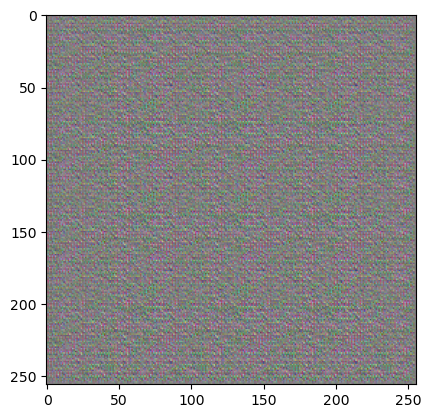

In [ ]:
image_noise = fake_images.detach().numpy().reshape((3,256,256))*0.5 + 0.5

plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.show()

## Training using the Unet based discriminator without CutMix


In [8]:
from utils import (Unet_Discriminator, unet_d_criterion_without_cutmix)
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
import time

torch.autograd.set_detect_anomaly(True)

input_channels = 3
n_classes = 2
k = 3 # Steps to train generator
noise_dim = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device) 

G_unet = Generator(latent_dim, channels_out).to(device)
D_unet = Unet_Discriminator(input_channels, n_classes=n_classes).to(device)

criterion = unet_d_criterion_without_cutmix

optimizer_g_unet = optim.Adam(G_unet.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d_unet = optim.Adam(D_unet.parameters(), lr=0.0002, betas=(0.5, 0.999)) 

epochs = 20

for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):
        # Get real images
        real_images = batch.to(device)  # Move batch to GPU
        batch_size = real_images.size(0)
        labels_1 = torch.ones(batch_size, 1, device=device)  # Real labels on GPU
        labels_2 = torch.ones(batch_size, 1, device=device)

        # Train discriminator with real images
        D_unet.zero_grad()
        output = D_unet(real_images)
        loss_d_real = criterion(output, labels_1, batch_size)

        # Train discriminator with fake images
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)  # Generate noise on GPU
        fake_images = G_unet(noise)
        labels_2.fill_(0)  # Fake labels
        output = D_unet(fake_images.detach())
        loss_d_fake = criterion(output, labels_2, batch_size)
        
        loss_d = loss_d_fake + loss_d_real
        loss_d.backward()
        optimizer_d_unet.step()

        if epoch % k == 0:
            # Train generator
            labels_3 = torch.ones(batch_size, 1, device=device)
            G_unet.zero_grad()
            labels_3.fill_(1)  # Real labels
            output = D_unet(fake_images)
            loss_g = criterion(output, labels_3, batch_size)
            loss_g.backward()
            optimizer_g_unet.step()
    
    end_time = time.time()
    if epoch % k == 0:

        print(f'Epoch [{epoch}/{num_epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    else:
    
        print(f'Epoch [{epoch}/{num_epochs}] | Loss D: {loss_d.item()}')
    
    print(f'Epoch {epoch +1} duration :   {end_time - start_time}')


cuda


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

In [26]:
from utils import Unet_Generator, Unet_Discriminator, unet_d_criterion_without_cutmix
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
import time

torch.autograd.set_detect_anomaly(True)

# Parameters
input_channels = 3
n_classes = 2
k = 3  # Steps to train generator
noise_dim = 128
epochs = 30  # Total number of epochs

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Initialize models
G_unet = Unet_Generator(latent_dim, channels_out).to(device)  # Ensure latent_dim and channels_out are defined
D_unet = Unet_Discriminator(input_channels, n_classes=n_classes).to(device)

# Loss function and optimizers
criterion = unet_d_criterion_without_cutmix
optimizer_g_unet = optim.Adam(G_unet.parameters(), lr=1e-4, betas=(0.99, 0.999))
optimizer_d_unet = optim.Adam(D_unet.parameters(), lr=1e-4, betas=(0.99, 0.999))

for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):
        real_images = batch.to(device)
        batch_size = real_images.size(0)

        # Labels for real and fake images
        labels_real = torch.ones(batch_size, 1, device=device)
        labels_fake = torch.zeros(batch_size, 1, device=device)

        # Train discriminator with real images
        D_unet.zero_grad()
        output = D_unet(real_images)
        loss_d_real = criterion(output, labels_real, batch_size)

        # Train discriminator with fake images
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        fake_images = G_unet(noise)
        output = D_unet(fake_images.detach())
        loss_d_fake = criterion(output, labels_fake, batch_size)

        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optimizer_d_unet.step()

        if epoch % k == 0:
            # Train generator
            G_unet.zero_grad()
            output = D_unet(fake_images)
            loss_g = criterion(output, labels_real, batch_size)  # Labels for generator are real
            loss_g.backward()
            optimizer_g_unet.step()

    end_time = time.time()
    if epoch % k == 0:
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    else:
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()}')

    print(f'Epoch {epoch + 1} duration: {end_time - start_time}')


cuda


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

torch.Size([1, 3, 128, 128])


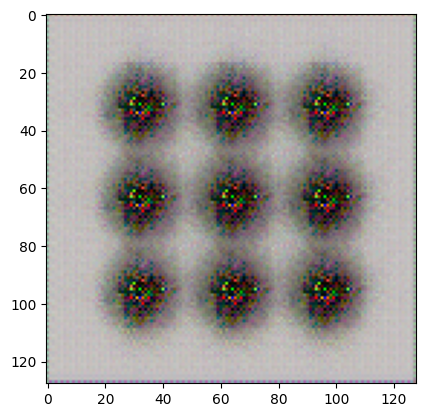

In [25]:
import torch

# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

G_unet_test = G_unet.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

print(fake_images.size())  # Should be (16, img_channels, height, width)

image_noise = fake_images.detach().numpy().reshape((3,128,128))*0.5 + 0.5

plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.show()